This file will be used to train the policies and use them to generate the trajectories. 

Let's start by creating the environment we will be using: Cartpool

In [34]:
%load_ext autoreload
%autoreload 2
%aimport -numpy
%aimport -torch
%aimport -gym

import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
torch.manual_seed(0)

# for saving/loading
import os

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [36]:
env = gym.make('CartPole-v0')
env.seed(0)

[0]

For the definition of classes and functions for training the policies, refer to train_policy_func.py file 

In [37]:
# to test

from Train_policy_func import Policy, device
from Generate_traj_func import generate_trajectory

policy = Policy(state_size=4, action_size=2).to(device)
# optionally: policy.load_state_dict(torch.load("best_policy.pth"))

# Generate one trajectory: 
traj = generate_trajectory(policy, env)
print(f"Episode length: {len(traj)}, Total reward: {sum(s['reward'] for s in traj)}")



Episode length: 17, Total reward: 17.0


In [38]:
# Training loop for PPO

from PPO import ppo_update, RolloutBuffer

# "In practice you’ll often tune these three carefully":
# clip_eps in [0.1, 0.3]
# lam in [0.90, 0.98]
# lr in [1e-5, 1e-3]"

# Hyperparameters
env_name     = "CartPole-v0"
total_steps  = 500     # per update
updates      = 1000        # how many times to run rollout+update
clip_eps     = 0.2      # PPO clipping parameter
gamma, lam   = 0.99, 0.95 # GAE parameters
lr           = 0.003
batch_size   = 64
epochs       = 4

# decaying entropy coefficient
entropy_coef_start = 0.02
entropy_coef_end   = 1e-4       # or a small floor like 1e-4
max_updates = updates 

# Instantiate
env       = gym.make(env_name)
policy    = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=lr)
buffer    = RolloutBuffer()
avg_returns = []

for update in range(updates):
    state = env.reset()
    steps = 0

    # for tracking episode returns within this batch
    episode_rewards     = []
    current_ep_reward   = 0.0

    # 1) Roll out until we have total_steps
    while steps < total_steps:
        action, logp, value = policy.act(state)
        next_state, reward, done, _ = env.step(action)
        buffer.store(state, action, logp, reward, value, done)
        state = next_state
        steps += 1

        # accumulate for this episode
        current_ep_reward += reward

        if done:
            episode_rewards.append(current_ep_reward)
            current_ep_reward = 0.0
            state = env.reset()

    # in case the last episode didn’t terminate exactly on total_steps
    if current_ep_reward > 0.0:
        episode_rewards.append(current_ep_reward)

    # compute average return for this batch
    avg_ret = np.mean(episode_rewards)
    avg_returns.append(avg_ret)

    # 2) Compute last value (for GAE)
    _, last_value = policy(torch.from_numpy(state).float().unsqueeze(0).to(device))

    # 2.5) Linear-decay schedule:
    frac = 1.0 - (update - 1) / float(max_updates)
    entropy_coef = entropy_coef_end + frac * (entropy_coef_start - entropy_coef_end)

    # Or exponential:
    # entropy_coef = entropy_coef_start * math.exp(-decay_rate * (update - 1))

    # 3) PPO update
    ppo_update(policy, optimizer, buffer,entropy_coef, clip_eps, epochs, batch_size)

    # 4) Saving checkpoint of the policy to get pi2
    if (update ) % 200 == 0 and update < update/2:
        print(f"Update {update}/{updates} completed.")
        torch.save(policy.state_dict(), f"pi2_checkpoint_{update}.pth")

# 5) at the end, save pi1
torch.save(policy.state_dict(), "pi1_final.pth")
print("Saved final policy as pi1_final.pth")



Update 0/1000 completed.
Update 200/1000 completed.
Saved final policy as pi1_final.pth


In [39]:
## Generate preference pairs

# Load π₂ (weak) and π₁ (strong)
from pairs_generator import sample_preference_pairs

pi2 = Policy().to(device)
pi2.load_state_dict(torch.load("pi2_checkpoint_200.pth"))
pi2.eval()

pi1 = Policy().to(device)
pi1.load_state_dict(torch.load("pi1_final.pth"))
pi1.eval()

# Generate one trajectory each to inspect
traj1 = generate_trajectory(pi1, env, max_steps=1000)
traj2 = generate_trajectory(pi2, env, max_steps=1000)

print(f"π₂ → length {len(traj2)}, total reward {sum(s['reward'] for s in traj2):.1f}")
print(f"π₁ → length {len(traj1)}, total reward {sum(s['reward'] for s in traj1):.1f}")

prefs = sample_preference_pairs(pi1, pi2, env, K=200) # Need to define K elsewhere as hyperparameter
print(f"Collected {len(prefs)} preference pairs.")


C:\Users\turin\AppData\Local\Temp\ipykernel_66704\2183349200.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pi2.load_state_dict(torch.load("pi2_checkpoint_200.pth"))
C:

π₂ → length 45, total reward 45.0
π₁ → length 13, total reward 13.0
Collected 200 preference pairs.


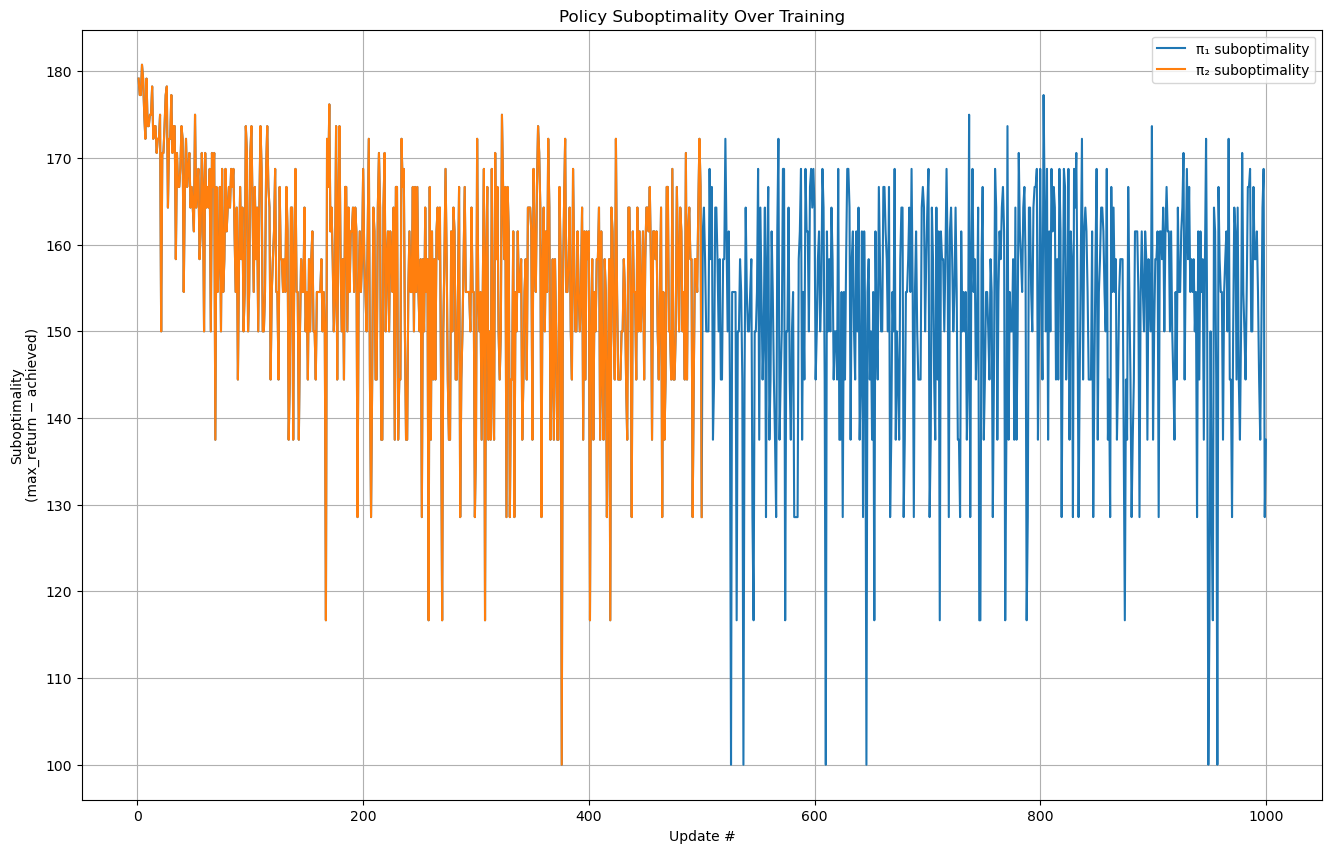

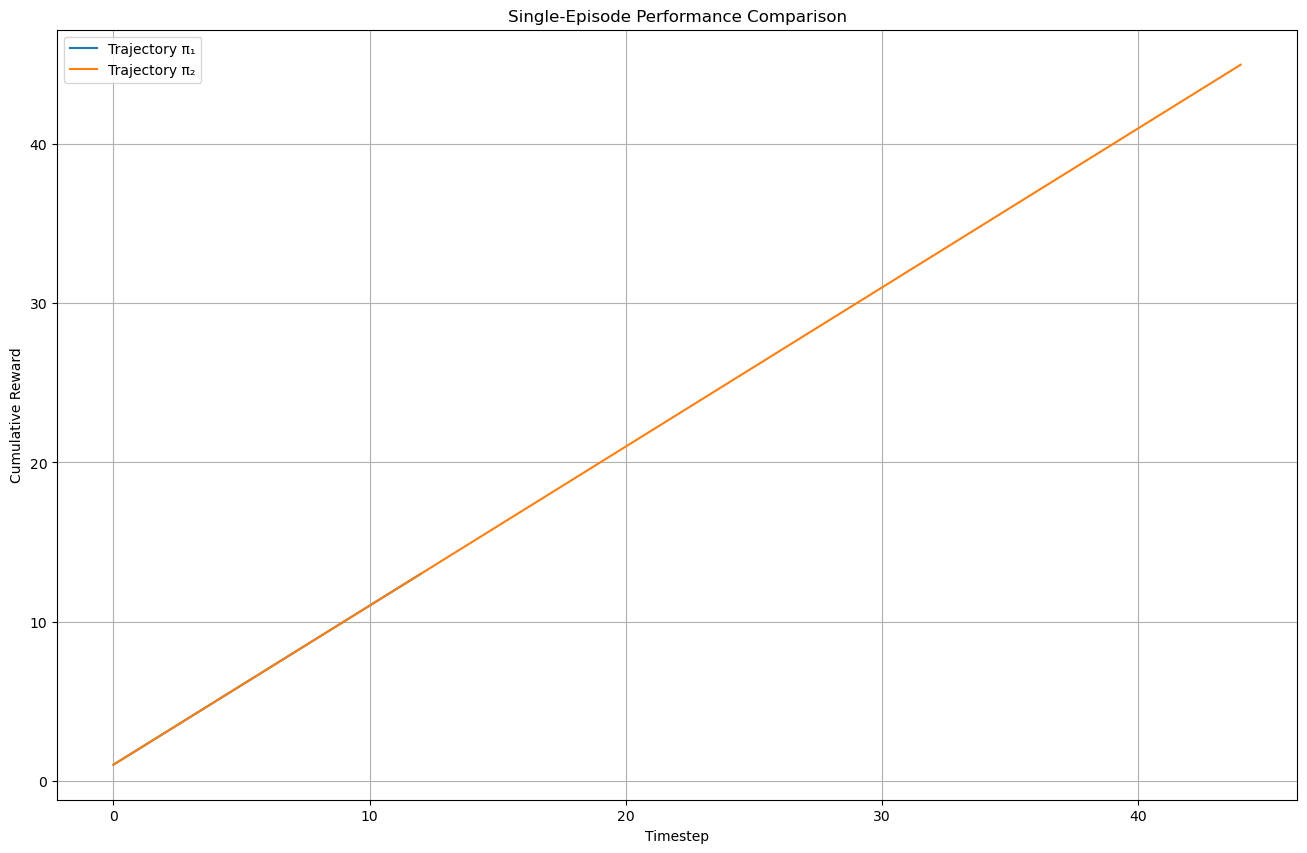

 size traj1: 13, size traj2: 45


In [40]:
## Visulization of the policies and trajectories
# %autoreload 2
from Generate_traj_func import plot_suboptimality, plot_trajectory_performance


plot_suboptimality(avg_returns, avg_returns[0:int(len(avg_returns)/2)],200) #in cartpole, 200 is the maximum reward
plot_trajectory_performance(traj1, traj2) 
print(f" size traj1: {len(traj1)}, size traj2: {len(traj2)}")

In [41]:
# Training loop for OPPO
from OPPO import baseline_1, OPPO_update
from Train_policy_func import Policy, device


# ── Re-instantiate a fresh policy & optimizer for OPPO ──
env_oppo   = gym.make(env_name)
policy_oppo = Policy(state_size=env_oppo.observation_space.shape[0],
                     action_size=env_oppo.action_space.n).to(device)
opt_oppo    = torch.optim.Adam(policy_oppo.parameters(), lr=lr)

# ── Hyperparams for OPPO ──
n_episodes = updates      # keep same “number of iterations” for fair comparison
max_t      = total_steps  # cap on steps per episode
print_every=100

# ── Run the OPPO training ──
scores_oppo = OPPO_update(
    policy       = policy_oppo,
    optimizer    = opt_oppo,
    env          = env_oppo,
    baseline     = baseline_1,
    n_episodes   = n_episodes,
    max_t        = max_t,
    gamma        = gamma,      # you can reuse your PPO γ
    print_every  = print_every,
    early_stop   = False
)

# ── Post-processing: smooth or average returns per “block” if you like
avg_scores_oppo = [
    np.mean(scores_oppo[i : i + print_every])
    for i in range(0, len(scores_oppo), print_every)
]




C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a d

Episode 100	Average Score: 21.54
Episode 200	Average Score: 31.96
Episode 300	Average Score: 105.64
Episode 400	Average Score: 167.36
Episode 500	Average Score: 199.39
Episode 600	Average Score: 197.12
Episode 700	Average Score: 183.69
Episode 800	Average Score: 187.74
Episode 900	Average Score: 189.34
Episode 1000	Average Score: 183.61


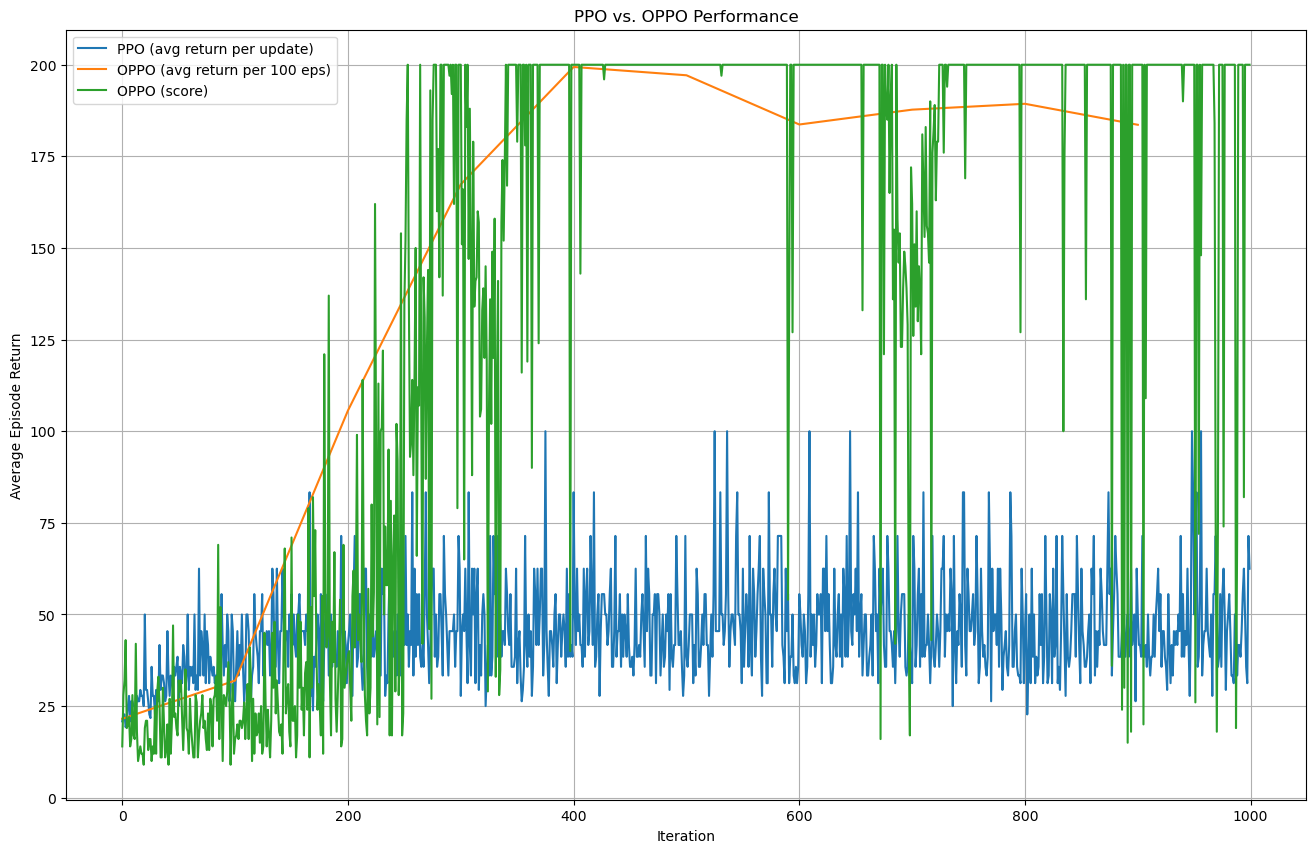

In [42]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(
    np.arange(len(avg_returns)), avg_returns,
    label="PPO (avg return per update)"
)
plt.plot(
    100*np.arange(len(avg_scores_oppo)), avg_scores_oppo,
    label=f"OPPO (avg return per {print_every} eps)"
)
plt.plot(
    np.arange(len(scores_oppo)), scores_oppo,
    label=f"OPPO (score)"
)
plt.xlabel("Iteration")
plt.ylabel("Average Episode Return")
plt.legend()
plt.grid(True)
plt.title("PPO vs. OPPO Performance")
plt.show()